# Pulse stream recovery under additive noise (cont.)

We continue the discussion from the previous notebook in which we considered **_additive noise_** that corrupts our measurements of a finite pulse stream:

\begin{align}
y_{meas}[n] = y_{BL}[n] + w[n],   \nonumber
\end{align}

where the values $w[n]$ can be modeled as zero-mean Gaussian noise $N(0, \sigma^2)$ and $y_{BL}[n]$ are the lowpass filtered samples of a (periodic) finite pulse stream, e.g.:

\begin{align}
y(t) = \sum_{n\in\mathbb{Z}}\sum_{k=0}^{K-1}c_k \hspace{0.05cm} h(t-t_k-nT), \nonumber
\end{align}

where $T$ is the period (or finite duration) of the pulse stream, $h(t)$ is a known pulse shape, and $\{c_k, t_k\}_{k=0}^{K-1}$ are the desired pulse parameters to estimate from the measured samples.

In the previous notebook, we saw how to exploit oversampled measurements, namely more samples than the degrees of freedom for the pulse $N\geq2K+1$, in order to estimate the pulse parameters from noisy samples. The discussed method, **_total least-squares_** (TLS) [1], exploited the rank of the Toeptliz matrix of Fourier coefficients, given by $K$ for $K$ pulses.

Although the approach worked well for high SNRs (signal-to-noise ratio) ($50$ dB for $K=6$ pulses), it quickly broke down for moderate SNR values ($10$ dB). This motivates an approach for **_denoising_** the estimated Fourier coefficients. Note that with TLS, no modifications are made to the estimated Fourier coefficients! 

There are multiple approaches for denoising; the one we will discuss in this notebook is **_Cadzow's iterative denoising_** [1]. In the previous notebook, we observed how it led to a successful recovery of the pulse parameters for an SNR of $10$ dB, which  proved difficult for TLS alone.

In [1]:
import numpy as np
import plot_settings
import sys
sys.path.append('..')

from frius import create_pulse_param, sample_ideal_project, estimate_fourier_coeff, add_noise, compute_ann_filt, estimate_time_param, estimate_amplitudes, evaluate_recovered_param

# 1. Cadzow's iterative denoising

As TLS, Cadzow's iterative denoising exploits the rank property in order to denoise the estimated Fourier coefficients. Recall our Toeplitz matrix of Fourier coefficients: 

\begin{align}
\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}}) = \begin{bmatrix} 
\hat{x}[\mathrel{{-M}{+}{K}}]&\hat{x}[\mathrel{{-M}{+}{K}{-}{1}}] & \cdots & \hat{x}[-M]\\
\vdots&\ddots &  \ddots & \vdots\\
\hat{x}[1] & \hat{x}[0] &   \cdots & \hat{x}[\mathrel{{-K}{+}{1}}] \\ 
\hat{x}[2] & \hat{x}[1] &  \cdots & \hat{x}[\mathrel{{-K}{+}{2}}] \\ 
\vdots&\vdots& \ddots & \vdots\\
\hat{x}[M] & \hat{x}[\mathrel{{M}{-}{1}}]  & \cdots & \hat{x}[\mathrel{{M}{-}{K}}]
\end{bmatrix},  \nonumber
\end{align}

If we can safely assume that the number of pulses is $K$, we saw earlier that $\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}})$ should have a rank of $K$ in the noiseless scenario. The rank of $\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}})$ will most likely increase when we obtain noisy estimated of the Fourier coefficients. 

As a "proxy" for measuring the rank, we can perform a singular value decomposition (SVD) and observe the raio between the $K^{th}$ and $(\mathrel{{K}{+}{1}})^{th}$ singular value. In the noiseless case, the $(\mathrel{{K}{+}{1}})^{th}$ singular value will be zero due to the rank property, resulting in a very large ratio between $K^{th}$ and $(\mathrel{{K}{+}{1}})^{th}$ singular value if we are close to the noiseless case. We can verify this below with "noiseless" Fourier coefficients as numerical errors are inevitable.

In [2]:
from frius import Tmtx      # function to create Toeplitz convolution matrix, defined in `frius/fri_utils.py`
from scipy.linalg import svd

# signal parameters
K = 6
period = 1
ck, tk = create_pulse_param(K=K, period=period)

# sample
oversample_freq = 2
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, oversample_freq=oversample_freq)

# check singular value ratio
fs_coeff_hat = estimate_fourier_coeff(y_samp, t_samp)
T = Tmtx(fs_coeff_hat, K)
s = svd(T)[1]
print("K/(K+1) singular value = %f\n" % (s[K-1]/s[K]))

K/(K+1) singular value = 61065944870001.031250



For decreasing SNRs, we can then observe how this ratio decreases decreases *exponentially*, see the figure below and note that the $y$-axis is in log scale.

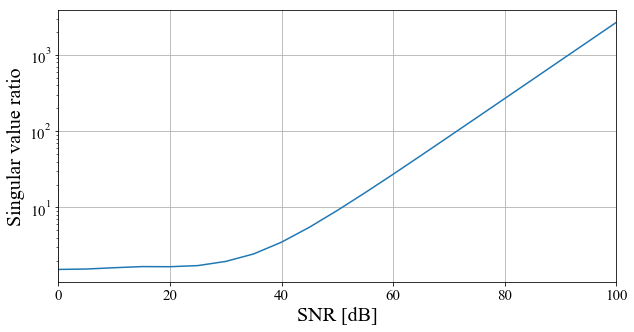

In [3]:
# signal parameters
K = 6
period = 1
oversample_freq = 2

# sweep parameters
snr_vals = np.arange(100, -1, -5)
n_trials = 20
ratios = np.zeros((len(snr_vals), n_trials))
for seed in range(n_trials):
    ck, tk = create_pulse_param(K=K, period=period, seed=seed)
    y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, oversample_freq=oversample_freq)
    for k, snr_db in enumerate(snr_vals):
        y_noisy = add_noise(y_samp, snr_db=snr_db)
        fs_coeff_hat = estimate_fourier_coeff(y_noisy, t_samp)
        T = Tmtx(fs_coeff_hat, K)
        s = svd(T)[1]
        ratios[k, seed] = s[K-1]/s[K]
avg_ratios = np.mean(ratios, axis=1)

plt.figure(figsize=(10,5))
plt.semilogy(snr_vals, avg_ratios)
plt.grid()
plt.xlabel("SNR [dB]")
plt.xlim([min(snr_vals), max(snr_vals)])
plt.ylabel("Singular value ratio");

How can we remedy this situation? Namely, how can we prevent such a decline in the singular value ratio? If we return to the SVD of our Toeplitz matrix:

\begin{align}
\mathbf{T}(\mathbf{\hat{x}_{noisy}}, L)  = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^H \text{ where } L \geq K+1, \nonumber
\end{align}

our desired result (for $K$ pulses) is that we have at most $K$ non-zero singular values in $ \mathbf{\Sigma} \in \mathbb{C}^{(2M+1-K)\times L} $. If this is not the case, we could think of **_projecting_** $\mathbf{\Sigma}$ to a matrix consisting of only the $K$ largest singular values, $\rightarrow \mathbf{\Sigma}'$.

As $ \mathbf{\Sigma}$ is a rectangular diagonal matrix with singular values in decreasing order along the diagonal, this projection consists of simply "zero-ing" those diagonal entries after the $K^{th}$ value. We could then construct a matrix of rank $K$ as such:

\begin{align}
\mathbf{F}_K = \mathbf{U} \mathbf{\Sigma}' \mathbf{V}^H. \nonumber
\end{align}

However, this new matrix of rank $K$ may no longer have a Toeplitz structure, i.e. constant along the diagonals. In order to preserve this property we could simply average along the diagonals. As the constants along the diagonals correspond to Fourier coefficients (see matrix above), we can extract the **_denoised_** coefficients as those values along  each diagonal. 

Those two steps are the keys components of Cadzow's iterative denoising! Namely:
1. Projecting to low rank matrix with the SVD.
2. Averaging along diagonals to maintain Toeplitz structure.

The last step will most likely increase the rank of the matrix so the two steps are repeated for a fixed number of iterations or until the ratio between the $K^{th}$ and $(\mathrel{{K}{+}{1}})^{th}$ singular value reaches a desired threshold. Once the stopping criterion has been met, the denoised Fourier coefficients can be extracted along the diagonals of the new Toeplitz matrix.

# 2. Code and simulation

Below we implement a function that performs Cadzow's iterative denoising. An additional degree of freedom for the denoising approach is the number of columns $L$ in the Toeplitz matrix. In [1], they suggest creating a Toeplitz that is as square as possible.

In [4]:
def cadzow_denoising(fs_coeff, K, L=None, n_iter=10, thresh=None, verbose=False):
    
    n_coeff = len(fs_coeff)
    if L is None:
        L = int(np.floor(0.5*n_coeff))
       
    # iterative denoising
    fs_coeff_denoised = fs_coeff.copy()
    diag_idx = L - np.arange(n_coeff)
    S_tild = np.zeros((n_coeff-L, L+1), dtype=np.complex)
    for k in range(n_iter):
        
        # form Toeplitz
        T = Tmtx(fs_coeff_denoised, L)
        
        # project to rank K
        U, s, Vh = svd(T)
        if verbose:
            print("ITERATION %d : K/(K+1) singular value = %f" % (k, s[K-1]/s[K]))
        if thresh is not None:
            if (s[K-1]/s[K]) >= thresh:  
                break
        for d in range(K):
            S_tild[d,d] = s[d]
        T_tild = np.dot(np.dot(U, S_tild), Vh)
        
        # average along diagonal
        for i, m in enumerate(diag_idx):
            fs_coeff_denoised[i] = np.mean(np.diag(T_tild, m))
            
    return fs_coeff_denoised 

The above function is also defined in `'frius/fri_utils.py'`.

In order to get a better idea of the algorithm performance, we suggest playing with the key denoising parameters below:
* oversampling factor: `oversample_fact`
* number of columns: `L`
* number of Cadzow iterations: `n_iter`

ITERATION 0 : K/(K+1) singular value = 1.241812
ITERATION 1 : K/(K+1) singular value = 12.872672
ITERATION 2 : K/(K+1) singular value = 34.988395
ITERATION 3 : K/(K+1) singular value = 90.494551
ITERATION 4 : K/(K+1) singular value = 229.129927
ITERATION 5 : K/(K+1) singular value = 574.253028
ITERATION 6 : K/(K+1) singular value = 1425.610518
ITERATION 7 : K/(K+1) singular value = 3422.334883
ITERATION 8 : K/(K+1) singular value = 8214.301290
ITERATION 9 : K/(K+1) singular value = 19717.845421

K/(K+1) singular value = 511856.285185

||tk - tk_hat||_2 = 0.003656 
||ck - ck_hat||_2 = 0.303609 


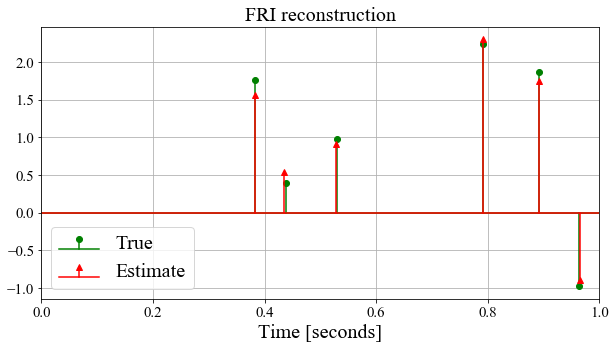

In [5]:
# signal parameters
K = 6
period = 1
ck, tk = create_pulse_param(K=K, period=period)

# denoising parameters
oversample_freq = 7
L = None       # "None" for defaulting to square Toeplitz
n_iter = 10

# sample
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, oversample_freq=oversample_freq)

# add noise
snr_db = 10
y_noisy = add_noise(y_samp, snr_db=snr_db)

# apply cadzow denoising
fs_coeff_hat = estimate_fourier_coeff(y_noisy, t_samp)
fs_coeff_denoised = cadzow_denoising(fs_coeff_hat, K, L=L, n_iter=n_iter, verbose=True)
print()

# recovery
freqs = fs_ind_base/period
ann_filt = compute_ann_filt(fs_coeff_denoised, K, print_ratio=True)
tk_hat = estimate_time_param(ann_filt, period)
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, figsize=(10,5), t_max=period)
plt.legend(loc="lower left");

In the next notebook, we will use this motivation of SNR to deal with **_modulated_** pulses, i.e. pulses that are not centered at baseband. We can intuitively see that in order to have a better SNR in our measurements, we should not stick to using those Fourier coefficients around baseband _but rather_ those coefficients centered around the modulation frequency of our pulse.

# References

    [1] T. Blu, P. L. Dragotti, M. Vetterli, P. Marziliano and L. Coulot, "Sparse Sampling of Signal Innovations," in IEEE Signal Processing Magazine, vol. 25, no. 2, pp. 31-40, March 2008.